In [1]:
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import time
import json

from sklearn.neural_network import MLPClassifier

In [3]:
DATASET_NAME = 'mnist'
# DATASET_NAME = 'wine_quality'

# DIM_RED_METHOD = 'ICA'
DIM_RED_METHOD = 'LLE'

SAVE = True
K_FOLDS = 5

In [4]:
if DATASET_NAME == 'wine_quality':
    DATASET_STR = 'Wine Quality'
    X_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_train.pkl', 'rb'))
    y_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_train.pkl', 'rb'))
    X_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_test.pkl', 'rb'))
    y_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_test.pkl', 'rb'))
elif DATASET_NAME == 'mnist':
    DATASET_STR = 'MNIST'
    X_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_train.pkl', 'rb'))
    y_train = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_train.pkl', 'rb'))
    X_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/X_test.pkl', 'rb'))
    y_test = pickle.load(open(f'transformed_data/{DATASET_NAME}/{DIM_RED_METHOD}/y_test.pkl', 'rb'))
else:
    raise ValueError(f'Invalid dataset name {DATASET_NAME}')

In [5]:
# get the number of instances of each label in y
for i in np.unique(y_train):
    print(f'Label {i}: {np.sum(y_train == i)} instances')

Label 0: 5923 instances
Label 1: 6742 instances
Label 2: 5958 instances
Label 3: 6131 instances
Label 4: 5842 instances
Label 5: 5421 instances
Label 6: 5918 instances
Label 7: 6265 instances
Label 8: 5851 instances
Label 9: 5949 instances


In [6]:
df = pd.DataFrame()
n = X_train.shape[0] // K_FOLDS

for i in tqdm(range(K_FOLDS)):
    X_train_k = np.concatenate([X_train[:i * n], X_train[(i + 1) * n:]])
    y_train_k = np.concatenate([y_train[:i * n], y_train[(i + 1) * n:]])
    X_test_k = X_train[i * n:(i + 1) * n]
    y_test_k = y_train[i * n:(i + 1) * n]

    model = MLPClassifier(hidden_layer_sizes=[10], max_iter=500, random_state=i, early_stopping=True, n_iter_no_change=50, verbose=False)

    t0 = time.perf_counter()
    model.fit(X_train_k, y_train_k)
    t1 = time.perf_counter()
    training_time = t1 - t0

    t0 = time.perf_counter()
    y_test_pred = model.predict(X_test_k) 
    t1 = time.perf_counter()
    evaluation_time = t1 - t0

    df.loc[i, 'training_time'] = training_time
    df.loc[i, 'evaluation_time'] = evaluation_time
    df.loc[i, 'fold'] = i
    df.loc[i, 'training_curve'] = json.dumps(model.loss_curve_)
    df.loc[i, 'validation_scores'] = json.dumps(model.validation_scores_)

    test_accuracy = np.mean(y_test_pred == y_test_k)
    df.loc[i, 'test_accuracy'] = test_accuracy

100%|██████████| 5/5 [10:21<00:00, 124.35s/it]


(0.95, 1.0)

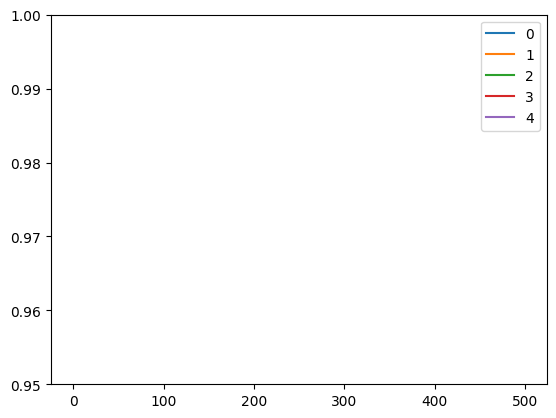

In [7]:
import matplotlib.pyplot as plt
val0 = eval(df['validation_scores'][0])
val1 = eval(df['validation_scores'][1])
val2 = eval(df['validation_scores'][2])
val3 = eval(df['validation_scores'][3])
val4 = eval(df['validation_scores'][4])
plt.plot(val0, label='0')
plt.plot(val1, label='1')
plt.plot(val2, label='2')
plt.plot(val3, label='3')
plt.plot(val4, label='4')
plt.legend()
plt.ylim(0.95, 1)

In [8]:
df_path = f'results/step_4/{DATASET_NAME}/{DIM_RED_METHOD}_metrics.csv'
os.makedirs(os.path.dirname(df_path), exist_ok=True)
df.to_csv(df_path, index=False)